<a href="https://colab.research.google.com/github/tnfru/colab_research/blob/master/keras_flowers_80percent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's train this model on TPU. It's worth it.

## Imports

In [0]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

TensorFlow 2.x selected.
Tensorflow version 2.1.0


## TPU detection

In [0]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: 10.11.17.98:8470


INFO:tensorflow:Initializing the TPU system: 10.11.17.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  grpc://10.11.17.98:8470
Number of accelerators:  8


## Configuration

In [0]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

if tpu:
  BATCH_SIZE = 16*strategy.num_replicas_in_sync  # A TPU has 8 cores so this will be 128
else:
  BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)

VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 128, there will be 23 batches per training epoch and 5 batch(es) per validation run.


In [0]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  # In eager mode, iterate in the Datset directly.
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  # one-hot to class number
  correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[np.argmax(labels[i], axis=-1)]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Read images and labels from TFRecords

In [0]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

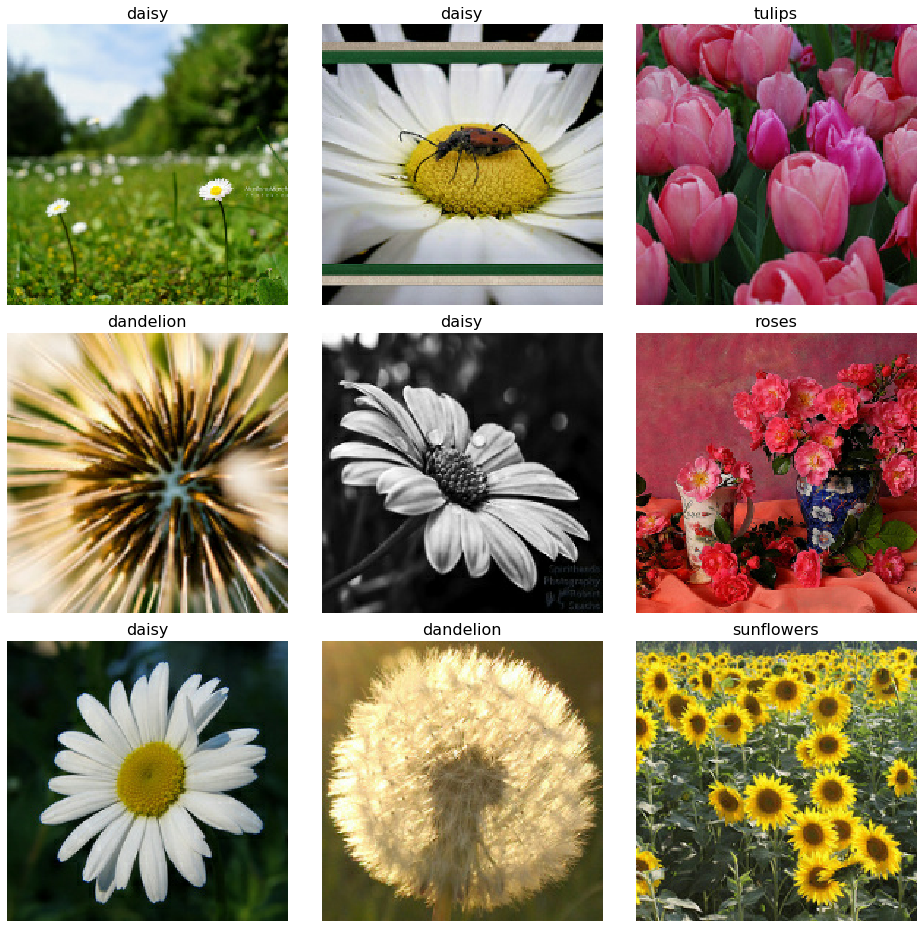

In [0]:
display_9_images_from_dataset(load_dataset(training_filenames))

## training and validation datasets

In [0]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

some_flowers, some_labels = dataset_to_numpy_util(load_dataset(validation_filenames), 160)

## Model [WORK REQUIRED]
1. train the model as it is, with a single convolutional layer
 * Accuracy 40%... Not great.
2. add additional convolutional layers interleaved with max-pooling layers. Try also adding a second dense layer. For example:<br/>
`conv 3x3, 16 filters, relu`<br/>
`conv 3x3, 30 filters, relu`<br/>
`max pool 2x2`<br/>
`conv 3x3, 50 filters, relu`<br/>
`max pool 2x2`<br/>
`conv 3x3, 70 filters, relu`<br/>
`flatten`<br/>
`dense 5 softmax`<br/>
 * Accuracy 60%... slightly better. But this model is more than 800K parameters and it overfits dramatically (overfitting = eval loss goes up instead of down).
3. Try replacing the Flatten layer by Global average pooling.
 * Accuracy still 60% but the model is back to a modest 50K parameters, and does not overfit anymore. If you train longer, it can go even higher.
4. Try experimenting with 1x1 convolutions too. They typically follow a 3x3 convolution and decrease the filter count. You can also add dropout between the dense layers. For example:
`conv 3x3, 20 filters, relu`<br/>
`conv 3x3, 50 filters, relu`<br/>
`max pool 2x2`<br/>
`conv 3x3, 70 filters, relu`<br/>
`conv 1x1, 50 filters, relu`<br/>
`max pool 2x2`<br/>
`conv 3x3, 100 filters, relu`<br/>
`conv 1x1, 70 filters, relu`<br/>
`max pool 2x2`<br/>
`conv 3x3, 120 filters, relu`<br/>
`conv 1x1, 80 filters, relu`<br/>
`max pool 2x2`<br/>
`global average pooling`<br/>
`dense 5 softmax`<br/>
 * accuracy 70%
5. The goal is 80% accuracy ! Good luck. (You might want to train for more than 20 epochs to get there. Se your trainig curves to see if it is worth training longer.)

In [0]:
with strategy.scope(): # this line is all that is needed to run on TPU (or multi-GPU, ...)

  model = tf.keras.Sequential([

      ###
      tf.keras.layers.InputLayer(input_shape=[*IMAGE_SIZE, 3]),
      tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(kernel_size=3, filters=100, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(kernel_size=3, filters=120, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(kernel_size=3, filters=150, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=40, padding='same', activation='relu'),



      #
      # LAYERS TO TRY:
      # Conv2D(kernel_size=3, filters=30, padding='same', activation='relu')
      # MaxPooling2D(pool_size=2)
      # GlobalAveragePooling2D() / Flatten()
      # Dense(90, activation='relu')
      #
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(90, activation='relu'),
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.Dense(5, activation='softmax')
      ###
  ])

  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

  model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 192, 192, 16)      448       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 192, 192, 32)      4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 48, 48, 100)       57700     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 100)      

## Training

In [0]:
EPOCHS = 60


history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset)

Train for 23 steps
Epoch 1/60
23/23 [==============================] - 18s 795ms/step - loss: 1.5576 - accuracy: 0.2768 - val_loss: 1.5112 - val_accuracy: 0.2812
Epoch 2/60
23/23 [==============================] - 2s 71ms/step - loss: 1.4239 - accuracy: 0.3641 - val_loss: 1.3949 - val_accuracy: 0.3420
Epoch 3/60
23/23 [==============================] - 2s 71ms/step - loss: 1.2869 - accuracy: 0.3998 - val_loss: 1.2449 - val_accuracy: 0.4855
Epoch 4/60
23/23 [==============================] - 2s 72ms/step - loss: 1.1669 - accuracy: 0.5197 - val_loss: 1.1138 - val_accuracy: 0.5377
Epoch 5/60
23/23 [==============================] - 2s 71ms/step - loss: 1.0906 - accuracy: 0.5513 - val_loss: 1.0418 - val_accuracy: 0.5754
Epoch 6/60
23/23 [==============================] - 2s 70ms/step - loss: 1.0505 - accuracy: 0.5608 - val_loss: 1.0338 - val_accuracy: 0.5478
Epoch 7/60
23/23 [==============================] - 2s 71ms/step - loss: 1.0087 - accuracy: 0.5876 - val_loss: 0.9837 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


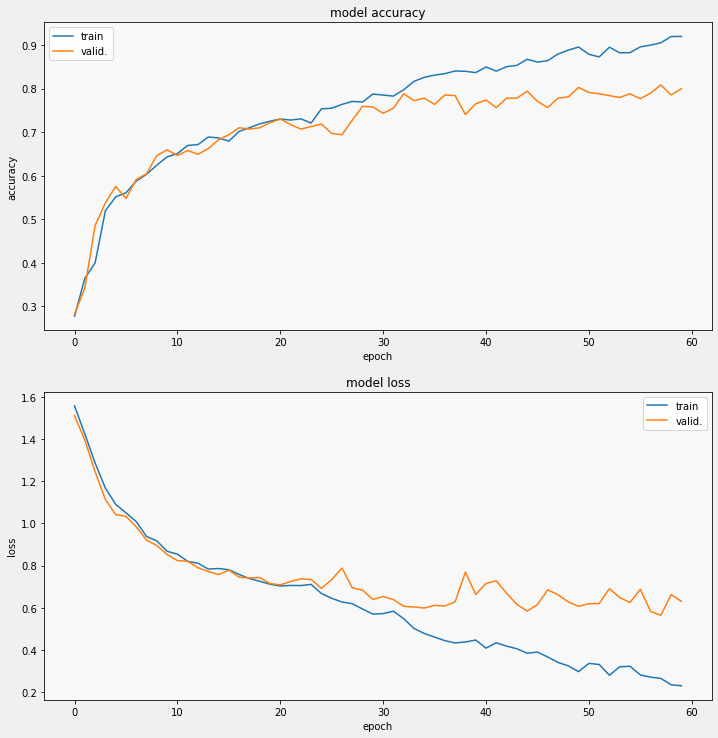

In [0]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Predictions

In [0]:
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(160)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = model.predict(some_flowers, batch_size=16)
evaluations = model.evaluate(some_flowers, some_labels, batch_size=16)
  
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)

160/160 [==============================] - 2s 11ms/sample - loss: 0.4509 - accuracy: 0.8562
['sunflowers', 'sunflowers', 'daisy', 'roses', 'dandelion', 'roses', 'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'daisy', 'tulips', 'dandelion', 'dandelion', 'daisy', 'dandelion', 'daisy', 'sunflowers', 'sunflowers', 'sunflowers', 'sunflowers', 'dandelion', 'tulips', 'daisy', 'dandelion', 'sunflowers', 'dandelion', 'sunflowers', 'roses', 'roses', 'dandelion', 'daisy', 'sunflowers', 'tulips', 'tulips', 'daisy', 'dandelion', 'dandelion', 'tulips', 'roses', 'dandelion', 'dandelion', 'roses', 'sunflowers', 'roses', 'dandelion', 'daisy', 'roses', 'dandelion', 'tulips', 'tulips', 'tulips', 'dandelion', 'sunflowers', 'daisy', 'tulips', 'tulips', 'daisy', 'roses', 'daisy', 'sunflowers', 'daisy', 'sunflowers', 'roses', 'tulips', 'tulips', 'tulips', 'sunflowers', 'daisy', 'roses', 'sunflowers', 'roses', 'daisy', 'dandelion', 'roses', 'dandelion', 'dandelion', 'sunflowers', 'daisy', 'dandelion', '

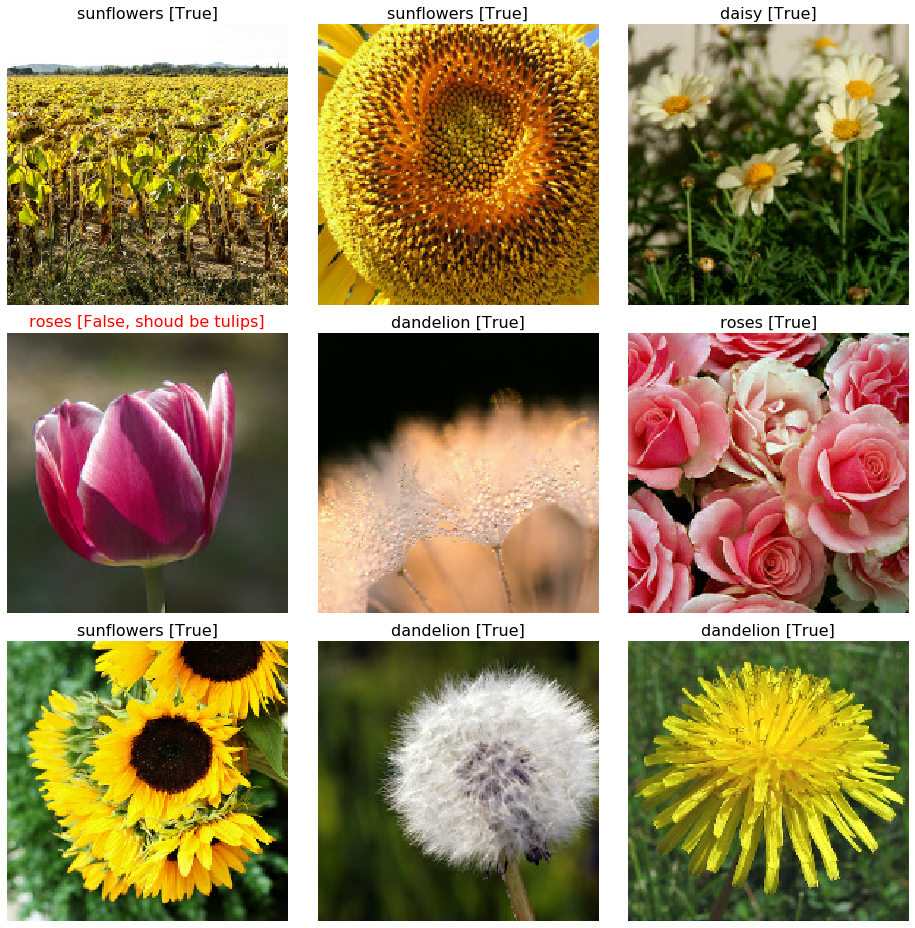

In [0]:
display_9_images_with_predictions(some_flowers, predictions, some_labels)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
